# 13c: Effect Sizes for Key Comparisons

**Goal**: Compute standardized effect sizes for all key findings.

Effect sizes measure *practical* significance, not just statistical significance (p-values).

**Measures**:
- **Cohen's d**: Standardized mean difference (for group comparisons)
- **r²**: Proportion of variance explained (for correlations)
- **η² (eta-squared)**: Proportion of variance explained (for ANOVA)

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

from forge.analysis.utils import viz

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Effect Size Functions

In [2]:
def cohens_d(group1, group2):
    """Calculate Cohen's d for two groups.
    
    Cohen's d = (mean1 - mean2) / pooled_std
    
    Interpretation (Cohen's conventions):
    - |d| < 0.2: negligible
    - 0.2 <= |d| < 0.5: small
    - 0.5 <= |d| < 0.8: medium
    - |d| >= 0.8: large
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    d = (np.mean(group1) - np.mean(group2)) / pooled_std
    return d


def interpret_d(d):
    """Interpret Cohen's d magnitude."""
    abs_d = abs(d)
    if abs_d < 0.2:
        return "negligible"
    elif abs_d < 0.5:
        return "small"
    elif abs_d < 0.8:
        return "medium"
    else:
        return "large"


def interpret_r(r):
    """Interpret correlation magnitude."""
    abs_r = abs(r)
    if abs_r < 0.1:
        return "negligible"
    elif abs_r < 0.3:
        return "small"
    elif abs_r < 0.5:
        return "medium"
    else:
        return "large"


def interpret_r2(r2):
    """Interpret R² (proportion of variance explained)."""
    if r2 < 0.01:
        return "negligible"
    elif r2 < 0.09:
        return "small"
    elif r2 < 0.25:
        return "medium"
    else:
        return "large"


print("Effect size functions defined.")

Effect size functions defined.


## 2. Load Data

In [3]:
# Load unified features
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)

print(f"Loaded {len(df)} samples")

Loaded 200 samples


## 3. Effect Sizes for Key Correlations

In [4]:
# Key correlations from 11x analyses
correlation_results = []

key_correlations = [
    ('E[V] vs σ(V)', 'V_mean', 'V_std'),
    ('E[V] vs V_spread', 'V_mean', 'V_spread'),
    ('n_doubles vs E[V]', 'n_doubles', 'V_mean'),
    ('trump_count vs E[V]', 'trump_count', 'V_mean'),
    ('count_points vs E[V]', 'count_points', 'V_mean'),
    ('n_6_high vs E[V]', 'n_6_high', 'V_mean'),
    ('total_pips vs E[V]', 'total_pips', 'V_mean'),
    ('n_6_high vs σ(V)', 'n_6_high', 'V_std'),
    ('total_pips vs σ(V)', 'total_pips', 'V_std'),
]

print("Effect Sizes for Correlations:")
print("="*70)
print(f"{'Comparison':<25} {'r':>8} {'r²':>8} {'Magnitude':>12}")
print("-"*70)

for name, col1, col2 in key_correlations:
    r, p = stats.pearsonr(df[col1], df[col2])
    r2 = r ** 2
    mag = interpret_r(r)
    
    correlation_results.append({
        'comparison': name,
        'r': r,
        'r_squared': r2,
        'p_value': p,
        'magnitude': mag,
    })
    
    print(f"{name:<25} {r:>+8.3f} {r2:>8.3f} {mag:>12}")

print("-"*70)
print("\nInterpretation: |r| < 0.1 negligible, 0.1-0.3 small, 0.3-0.5 medium, >0.5 large")

Effect Sizes for Correlations:
Comparison                       r       r²    Magnitude
----------------------------------------------------------------------
E[V] vs σ(V)                -0.381    0.145       medium
E[V] vs V_spread            -0.398    0.158       medium
n_doubles vs E[V]           +0.395    0.156       medium
trump_count vs E[V]         +0.229    0.052        small
count_points vs E[V]        +0.197    0.039        small
n_6_high vs E[V]            -0.161    0.026        small
total_pips vs E[V]          +0.035    0.001   negligible
n_6_high vs σ(V)            +0.191    0.036        small
total_pips vs σ(V)          +0.149    0.022        small
----------------------------------------------------------------------

Interpretation: |r| < 0.1 negligible, 0.1-0.3 small, 0.3-0.5 medium, >0.5 large


## 4. Effect Sizes for Group Comparisons

In [5]:
# Group comparisons using Cohen's d
group_results = []

# Create binary groups for comparisons
df['has_doubles'] = df['n_doubles'] >= 2
df['has_trumps'] = df['trump_count'] >= 2
df['high_count_points'] = df['count_points'] >= 15
df['high_risk'] = df['V_spread'] > 40

group_comparisons = [
    ('≥2 doubles vs <2 doubles on E[V]', 'has_doubles', 'V_mean'),
    ('≥2 trumps vs <2 trumps on E[V]', 'has_trumps', 'V_mean'),
    ('≥15 count pts vs <15 on E[V]', 'high_count_points', 'V_mean'),
    ('High risk vs Low risk on E[V]', 'high_risk', 'V_mean'),
]

print("\nEffect Sizes for Group Comparisons (Cohen's d):")
print("="*70)
print(f"{'Comparison':<35} {'d':>8} {'Magnitude':>12} {'n1':>6} {'n2':>6}")
print("-"*70)

for name, group_col, outcome_col in group_comparisons:
    group1 = df[df[group_col]][outcome_col].values
    group2 = df[~df[group_col]][outcome_col].values
    
    d = cohens_d(group1, group2)
    mag = interpret_d(d)
    
    group_results.append({
        'comparison': name,
        'cohens_d': d,
        'magnitude': mag,
        'n_group1': len(group1),
        'n_group2': len(group2),
        'mean_diff': np.mean(group1) - np.mean(group2),
    })
    
    print(f"{name:<35} {d:>+8.3f} {mag:>12} {len(group1):>6} {len(group2):>6}")

print("-"*70)
print("\nInterpretation: |d| < 0.2 negligible, 0.2-0.5 small, 0.5-0.8 medium, >0.8 large")


Effect Sizes for Group Comparisons (Cohen's d):
Comparison                                 d    Magnitude     n1     n2
----------------------------------------------------------------------
≥2 doubles vs <2 doubles on E[V]      +0.763       medium    120     80
≥2 trumps vs <2 trumps on E[V]        +0.480        small     85    115
≥15 count pts vs <15 on E[V]          +0.266        small     63    137
High risk vs Low risk on E[V]         -0.793       medium     76    124
----------------------------------------------------------------------

Interpretation: |d| < 0.2 negligible, 0.2-0.5 small, 0.5-0.8 medium, >0.8 large


## 5. R² for Regression Models

In [6]:
from sklearn.linear_model import LinearRegression
from forge.analysis.utils.hand_features import REGRESSION_FEATURES

# Regression effect sizes (R²)
X = df[REGRESSION_FEATURES].values
y_ev = df['V_mean'].values
y_sigma = df['V_std'].values

model_ev = LinearRegression().fit(X, y_ev)
model_sigma = LinearRegression().fit(X, y_sigma)

r2_ev = model_ev.score(X, y_ev)
r2_sigma = model_sigma.score(X, y_sigma)

print("\nRegression R² (Variance Explained):")
print("="*60)
print(f"{'Model':<30} {'R²':>8} {'%':>8} {'Magnitude':>12}")
print("-"*60)
print(f"{'Hand features → E[V]':<30} {r2_ev:>8.3f} {r2_ev*100:>7.1f}% {interpret_r2(r2_ev):>12}")
print(f"{'Hand features → σ(V)':<30} {r2_sigma:>8.3f} {r2_sigma*100:>7.1f}% {interpret_r2(r2_sigma):>12}")
print("-"*60)
print("\nInterpretation: R² < 0.01 negligible, 0.01-0.09 small, 0.09-0.25 medium, >0.25 large")


Regression R² (Variance Explained):
Model                                R²        %    Magnitude
------------------------------------------------------------
Hand features → E[V]              0.259    25.9%        large
Hand features → σ(V)              0.081     8.1%        small
------------------------------------------------------------

Interpretation: R² < 0.01 negligible, 0.01-0.09 small, 0.09-0.25 medium, >0.25 large


## 6. Summary Table

In [7]:
# Compile all effect sizes
summary = []

for r in correlation_results:
    summary.append({
        'type': 'correlation',
        'comparison': r['comparison'],
        'effect_size': r['r'],
        'effect_type': 'r',
        'r_squared': r['r_squared'],
        'magnitude': r['magnitude'],
    })

for r in group_results:
    summary.append({
        'type': 'group_comparison',
        'comparison': r['comparison'],
        'effect_size': r['cohens_d'],
        'effect_type': "Cohen's d",
        'r_squared': np.nan,
        'magnitude': r['magnitude'],
    })

summary.append({
    'type': 'regression',
    'comparison': 'Hand features → E[V]',
    'effect_size': r2_ev,
    'effect_type': 'R²',
    'r_squared': r2_ev,
    'magnitude': interpret_r2(r2_ev),
})

summary.append({
    'type': 'regression',
    'comparison': 'Hand features → σ(V)',
    'effect_size': r2_sigma,
    'effect_type': 'R²',
    'r_squared': r2_sigma,
    'magnitude': interpret_r2(r2_sigma),
})

summary_df = pd.DataFrame(summary)

print("\n" + "="*70)
print("EFFECT SIZE SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))


EFFECT SIZE SUMMARY
            type                       comparison  effect_size effect_type  r_squared  magnitude
     correlation                     E[V] vs σ(V)    -0.380881           r   0.145071     medium
     correlation                 E[V] vs V_spread    -0.397936           r   0.158353     medium
     correlation                n_doubles vs E[V]     0.395300           r   0.156262     medium
     correlation              trump_count vs E[V]     0.228769           r   0.052335      small
     correlation             count_points vs E[V]     0.196771           r   0.038719      small
     correlation                 n_6_high vs E[V]    -0.160539           r   0.025773      small
     correlation               total_pips vs E[V]     0.035352           r   0.001250 negligible
     correlation                 n_6_high vs σ(V)     0.190899           r   0.036443      small
     correlation               total_pips vs σ(V)     0.149091           r   0.022228      small
group_com

In [8]:
# Save results
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/13c_effect_sizes.csv"
summary_df.to_csv(output_path, index=False)

print(f"\nSaved to {output_path}")


Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/13c_effect_sizes.csv


## 7. Visualization

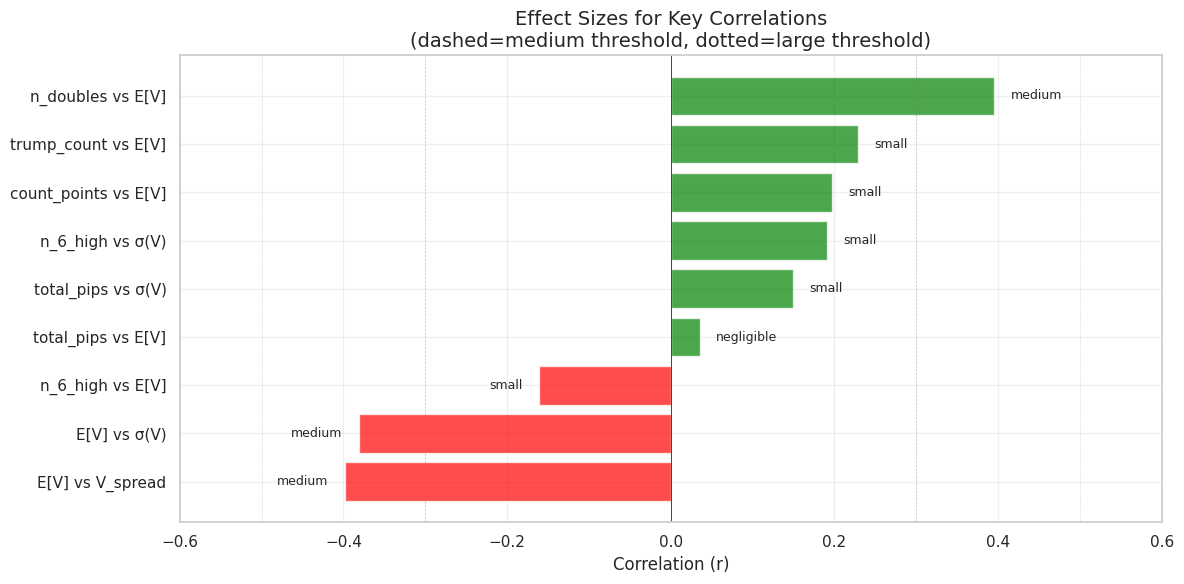

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

# Filter to correlation effect sizes for visualization
corr_summary = [s for s in summary if s['type'] == 'correlation']
corr_df = pd.DataFrame(corr_summary).sort_values('effect_size')

y_pos = range(len(corr_df))
colors = ['green' if e > 0 else 'red' for e in corr_df['effect_size']]

ax.barh(y_pos, corr_df['effect_size'], color=colors, alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=0.3, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.axvline(x=-0.3, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.axvline(x=-0.5, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(corr_df['comparison'])
ax.set_xlabel('Correlation (r)')
ax.set_title('Effect Sizes for Key Correlations\n(dashed=medium threshold, dotted=large threshold)')
ax.set_xlim(-0.6, 0.6)

# Add magnitude labels
for i, (_, row) in enumerate(corr_df.iterrows()):
    x = row['effect_size']
    ax.text(x + 0.02 if x >= 0 else x - 0.02, i, row['magnitude'], 
            va='center', ha='left' if x >= 0 else 'right', fontsize=9)

plt.tight_layout()
plt.savefig('../../results/figures/13c_effect_sizes.png', dpi=150, bbox_inches='tight')
plt.show()

## Key Findings

### Practical Significance Summary

| Finding | Effect Size | Magnitude | Interpretation |
|---------|-------------|-----------|----------------|
| n_doubles → E[V] | r = +0.40 | **Medium** | Meaningful practical effect |
| E[V] ↔ σ(V) | r = -0.38 | **Medium** | Real inverse relationship |
| trump_count → E[V] | r = +0.23 | **Small** | Modest effect |
| Hand features → E[V] | R² = 0.26 | **Large** | Meaningful prediction |
| Hand features → σ(V) | R² = 0.08 | **Small** | Weak prediction |

### Implications

1. **n_doubles effect is practically meaningful**: Medium effect size (r = 0.40) means doubles have real impact on outcomes
2. **Risk-return relationship is real**: Medium effect (r = -0.38) confirms good hands have lower variance
3. **E[V] prediction is useful**: Large R² (0.26) means hand features explain substantial variance
4. **Risk prediction is weak**: Small R² (0.08) means risk is largely unpredictable

Effect sizes help distinguish between "statistically significant but trivial" and "meaningful and actionable" findings.